In [40]:
import os
import numpy as np
import pandas as pd
import eipy.ei as e
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pickle as pkl

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
from eipy.additional_ensembles import MeanAggregation, CES
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate
import seaborn as sns
import warnings

data

In [2]:
directory = "/home/opc/block_vol/COVID-19 data"
data={}
for file_name in os.listdir(directory):
    if file_name.endswith('.csv') and not file_name.startswith('xgboost'):
        key = file_name.split('.')[0]
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        df = df.drop(columns=["NEW_MASKED_MRN"])
        imputer = KNNImputer(n_neighbors=5)
        df = imputer.fit_transform(df)
        data[key] = df

In [3]:
labels = pd.read_csv('/home/opc/block_vol/COVID-19 data/Basics/outcome.csv')
labels = labels["DECEASED_INDICATOR"]
labels.value_counts()

DECEASED_INDICATOR
0    3460
1    1323
Name: count, dtype: int64

dl bps

In [21]:
def build_deep_bps(input_dim):
    # Architecture 1: Simple Feedforward Neural Network
    model_1 = Sequential()
    model_1.add(Dense(64, input_dim=input_dim, activation='relu'))
    model_1.add(Dense(32, activation='relu'))
    model_1.add(Dense(1, activation='sigmoid'))
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 2: Deep Feedforward Neural Network with Dropout
    model_2 = Sequential()
    model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(64, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(32, activation='relu'))
    model_2.add(Dense(1, activation='sigmoid'))
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 3: Wide and Deep Neural Network
    input_layer = Input(shape=(input_dim,))
    wide_branch = Dense(32, activation='relu')(input_layer)
    deep_branch = Dense(64, activation='relu')(input_layer)
    deep_branch = Dense(32, activation='relu')(deep_branch)
    merged = Concatenate()([wide_branch, deep_branch])
    output_layer = Dense(1, activation='sigmoid')(merged)
    model_3 = Model(inputs=input_layer, outputs=output_layer)
    model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 4: Deep Neural Network without Sequential Structure
    model_4 = Sequential()
    model_4.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_4.add(Dense(64, activation='relu'))
    model_4.add(Dense(32, activation='relu'))
    model_4.add(Dense(1, activation='sigmoid'))
    model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    d_base_predictors = {"simple" : model_1,
                        "deep_w_dropout" : model_2,
                        # "wide_n_deep" : model_3,
                        # "deeper" : model_4
                         }
    return d_base_predictors

In [5]:
base_predictors = {
                    'ADAB': AdaBoostClassifier(),
                    'XGB': XGBClassifier(),
                    # 'DT': DecisionTreeClassifier(),
                    # 'RF': RandomForestClassifier(),
                    # 'GB': GradientBoostingClassifier(),
                    # 'KNN': KNeighborsClassifier(),
                    # 'LR': LogisticRegression(),
                    # 'NB': GaussianNB(),
                    # 'MLP': MLPClassifier(),
                    # 'SVM': SVC(probability=True),
}

In [6]:
ensemble_predictors = {
                    'Mean' : MeanAggregation(),
                    'CES' : CES(scoring=lambda y_test, y_pred: fmax_score(y_test, y_pred)[0]),
                    'S.ADAB': AdaBoostClassifier(),
                    'S.XGB': XGBClassifier(),
                    'S.DT': DecisionTreeClassifier(),
                    "S.RF": RandomForestClassifier(),
                    'S.GB': GradientBoostingClassifier(),
                    'S.KNN': KNeighborsClassifier(),
                    'S.LR': LogisticRegression(),
                    'S.NB': GaussianNB(),
                    'S.MLP': MLPClassifier(),
                    'S.SVM': SVC(probability=True),
}

In [7]:
metrics = {
            'f_max': fmax_score,
            'auc': roc_auc_score,
            'mcc': matthews_corrcoef
            }

EI

In [8]:
####HI OVER HERE###
reload(e)
###HEYOOOOOO#

<module 'eipy.ei' from '/home/opc/eipy/eipy/ei.py'>

In [9]:
# performance = {k:([],[]) for k in data.keys()}
# performance["EI"] = ([],[])
# for i in range(10):
#     random_seed= i
#     X_train = {}
#     X_test = {}
#     for k, v in data.items():
#         X_train[k], X_test[k], y_train, y_test = train_test_split(v, labels, test_size=0.2, stratify=labels, random_state=i)
#     for k in data.keys():
#         EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
        
#         EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
        
#         preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#         y_pred_fmax = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_fmax)
#         performance[k][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#         preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#         y_pred_auc = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_auc)
#         performance[k][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#         print(f"DONE WITH SEED {i}, MODALITY {k}")
    
#     EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#     for k in data.keys():
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
    
#     EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
#     preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#     y_pred_fmax = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_fmax)
#     performance["EI"][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#     preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#     y_pred_auc = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_auc)
#     performance["EI"][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#     print(f"DONE WITH SEED {i}")

In [25]:
warnings.filterwarnings('ignore')
performance = {}
for k in data.keys():
    # #modality alone structured
    # EI = e.EnsembleIntegration(
    #             k_outer=5,
    #             k_inner=5,
    #             n_samples=1,
    #             sampling_strategy="undersampling",
    #             sampling_aggregation=None,
    #             n_jobs=-1,
    #             metrics=metrics,
    #             random_state=38,
    #             project_name=f"{k}",
    #             model_building=False,
    #             )
    # EI.fit_base(data[k], labels, modality_name=k, base_predictors=base_predictors)
    
    # EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
    
    # performance[k] = EI.ensemble_summary

    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    # #modality alone unstructured
    # EI = e.EnsembleIntegration(
    #             k_outer=5,
    #             k_inner=5,
    #             n_samples=1,
    #             sampling_strategy="undersampling",
    #             sampling_aggregation=None,
    #             n_jobs=-1,
    #             metrics=metrics,
    #             random_state=38,
    #             project_name=f"{k} deep",
    #             model_building=False,
    #             )
    # EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
    
    # EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

    # performance[f"{k} deep"] = EI.ensemble_summary

    #EI with one modality unstructured
    if k=="labs":
        EI = e.EnsembleIntegration(
                        k_outer=5,
                        k_inner=5,
                        n_samples=3,
                        sampling_strategy="hybrid",
                        sampling_aggregation="mean",
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name=f"EI with {k} deep",
                        model_building=True,
                        )
        for m in data.keys():
            if m == k:
                EI.fit_base(data[m], labels, modality_name=m, base_predictors=d_base_predictors)
            else:
                EI.fit_base(data[m], labels, modality_name=m, base_predictors=base_predictors)
        
        EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

        performance[f"EI with {k} deep"] = EI.ensemble_summary

        print(f"DONE WITH MODALITY {k} YAYYYY!!!!")

# # normal EI
# EI = e.EnsembleIntegration(
#                 k_outer=5,
#                 k_inner=5,
#                 n_samples=1,
#                 sampling_strategy="undersampling",
#                 sampling_aggregation=None,
#                 n_jobs=-1,
#                 metrics=metrics,
#                 random_state=38,
#                 project_name="EI",
#                 model_building=False,
#                 )
# EI.fit_base(data, labels, base_predictors=base_predictors)
# EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

# performance["EI"] = EI.ensemble_summary

Training base predictors on labs...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

Epoch 1/10
383/383 [==============================] - 1s 914us/step - loss: 9.6049 - accuracy: 0.5957
Epoch 2/10
383/383 [==============================] - 0s 878us/step - loss: 6.0945 - accuracy: 0.6244
Epoch 3/10
383/383 [==============================] - 0s 890us/step - loss: 5.3148 - accuracy: 0.6260
Epoch 4/10
383/383 [==============================] - 0s 883us/step - loss: 3.3104 - accuracy: 0.6370
Epoch 5/10
383/383 [==============================] - 0s 881us/step - loss: 2.9215 - accuracy: 0.6479
Epoch 6/10
383/383 [==============================] - 0s 881us/step - loss: 3.0597 - accuracy: 0.6260
Epoch 7/10
383/383 [==============================] - 0s 885us/step - loss: 2.7319 - accuracy: 0.6500
Epoch 8/10
383/383 [==============================] - 0s 877us/step - loss: 3.0332 - accuracy: 0.6383
Epoch 9/10
383/383 [==============================] - 0s 878us/step - loss: 2.0731 - accuracy: 0.6573
Epoch 10/10
120/120 [==============================] - 0s 629us/step
Epoch 1/10
38

Generating ensemble training data: |██        | 20%

Epoch 1/10
383/383 [==============================] - 0s 860us/step - loss: 9.3496 - accuracy: 0.6072
Epoch 2/10
383/383 [==============================] - 0s 855us/step - loss: 3.9404 - accuracy: 0.6323
Epoch 3/10
383/383 [==============================] - 0s 856us/step - loss: 2.1644 - accuracy: 0.6519
Epoch 4/10
383/383 [==============================] - 0s 855us/step - loss: 2.3195 - accuracy: 0.6380
Epoch 5/10
383/383 [==============================] - 0s 857us/step - loss: 2.1711 - accuracy: 0.6485
Epoch 6/10
383/383 [==============================] - 0s 852us/step - loss: 1.3670 - accuracy: 0.6571
Epoch 7/10
383/383 [==============================] - 0s 843us/step - loss: 1.0437 - accuracy: 0.6681
Epoch 8/10
383/383 [==============================] - 0s 839us/step - loss: 1.0780 - accuracy: 0.6694
Epoch 9/10
383/383 [==============================] - 0s 836us/step - loss: 0.9829 - accuracy: 0.6733
Epoch 10/10
120/120 [==============================] - 0s 644us/step
Epoch 1/10
38

Generating ensemble training data: |████      | 40%

Epoch 1/10
383/383 [==============================] - 0s 866us/step - loss: 9.8680 - accuracy: 0.5896
Epoch 2/10
383/383 [==============================] - 0s 896us/step - loss: 2.8645 - accuracy: 0.6228
Epoch 3/10
383/383 [==============================] - 0s 836us/step - loss: 2.2172 - accuracy: 0.6262
Epoch 4/10
383/383 [==============================] - 0s 845us/step - loss: 3.0275 - accuracy: 0.6163
Epoch 5/10
383/383 [==============================] - 0s 850us/step - loss: 1.6383 - accuracy: 0.6417
Epoch 6/10
383/383 [==============================] - 0s 851us/step - loss: 1.7942 - accuracy: 0.6396
Epoch 7/10
383/383 [==============================] - 0s 854us/step - loss: 1.2102 - accuracy: 0.6568
Epoch 8/10
383/383 [==============================] - 0s 854us/step - loss: 1.7190 - accuracy: 0.6526
Epoch 9/10
383/383 [==============================] - 0s 854us/step - loss: 1.2746 - accuracy: 0.6445
Epoch 10/10
120/120 [==============================] - 0s 601us/step
Epoch 1/10
38

Generating ensemble training data: |██████    | 60%

Epoch 1/10
383/383 [==============================] - 0s 854us/step - loss: 9.8449 - accuracy: 0.6017
Epoch 2/10
383/383 [==============================] - 0s 841us/step - loss: 2.7781 - accuracy: 0.6411
Epoch 3/10
383/383 [==============================] - 0s 829us/step - loss: 2.8557 - accuracy: 0.6299
Epoch 4/10
383/383 [==============================] - 0s 840us/step - loss: 2.3182 - accuracy: 0.6451
Epoch 5/10
383/383 [==============================] - 0s 834us/step - loss: 1.9778 - accuracy: 0.6529
Epoch 6/10
383/383 [==============================] - 0s 841us/step - loss: 1.6515 - accuracy: 0.6461
Epoch 7/10
383/383 [==============================] - 0s 849us/step - loss: 2.1806 - accuracy: 0.6519
Epoch 8/10
383/383 [==============================] - 0s 849us/step - loss: 1.4313 - accuracy: 0.6636
Epoch 9/10
383/383 [==============================] - 0s 848us/step - loss: 1.9679 - accuracy: 0.6487
Epoch 10/10
120/120 [==============================] - 0s 636us/step
Epoch 1/10
38

Generating ensemble training data: |████████  | 80%

Epoch 1/10
383/383 [==============================] - 0s 863us/step - loss: 9.9569 - accuracy: 0.5954
Epoch 2/10
383/383 [==============================] - 0s 861us/step - loss: 3.7840 - accuracy: 0.6168
Epoch 3/10
383/383 [==============================] - 0s 868us/step - loss: 2.5294 - accuracy: 0.6281
Epoch 4/10
383/383 [==============================] - 0s 871us/step - loss: 2.6610 - accuracy: 0.6472
Epoch 5/10
383/383 [==============================] - 0s 864us/step - loss: 1.6586 - accuracy: 0.6641
Epoch 6/10
383/383 [==============================] - 0s 863us/step - loss: 2.3812 - accuracy: 0.6357
Epoch 7/10
383/383 [==============================] - 0s 840us/step - loss: 1.5262 - accuracy: 0.6534
Epoch 8/10
383/383 [==============================] - 0s 841us/step - loss: 1.3476 - accuracy: 0.6712
Epoch 9/10
383/383 [==============================] - 0s 844us/step - loss: 1.4442 - accuracy: 0.6571
Epoch 10/10
120/120 [==============================] - 0s 631us/step
Epoch 1/10
38

Generating ensemble training data: |██████████|100%
Generating ensemble training data: |          |  0%

Epoch 1/10
383/383 [==============================] - 1s 1ms/step - loss: 14.4411 - accuracy: 0.5081
Epoch 2/10
383/383 [==============================] - 0s 949us/step - loss: 2.5788 - accuracy: 0.5204
Epoch 3/10
383/383 [==============================] - 0s 959us/step - loss: 1.3175 - accuracy: 0.5251
Epoch 4/10
383/383 [==============================] - 0s 947us/step - loss: 1.0256 - accuracy: 0.5199
Epoch 5/10
383/383 [==============================] - 0s 958us/step - loss: 0.7748 - accuracy: 0.5408
Epoch 6/10
383/383 [==============================] - 0s 976us/step - loss: 0.8366 - accuracy: 0.5175
Epoch 7/10
383/383 [==============================] - 0s 965us/step - loss: 0.7340 - accuracy: 0.5120
Epoch 8/10
383/383 [==============================] - 0s 937us/step - loss: 0.7066 - accuracy: 0.5227
Epoch 9/10
383/383 [==============================] - 0s 938us/step - loss: 0.7074 - accuracy: 0.5251
Epoch 10/10
120/120 [==============================] - 0s 662us/step
Epoch 1/10
383

Generating ensemble training data: |██        | 20%

Epoch 1/10
383/383 [==============================] - 0s 952us/step - loss: 4.2608 - accuracy: 0.5201
Epoch 2/10
383/383 [==============================] - 0s 939us/step - loss: 0.7644 - accuracy: 0.5193
Epoch 3/10
383/383 [==============================] - 0s 953us/step - loss: 0.7439 - accuracy: 0.5084
Epoch 4/10
383/383 [==============================] - 0s 964us/step - loss: 0.7098 - accuracy: 0.5178
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5068
Epoch 6/10
383/383 [==============================] - 0s 961us/step - loss: 0.6921 - accuracy: 0.5439
Epoch 7/10
383/383 [==============================] - 0s 957us/step - loss: 0.6954 - accuracy: 0.5656
Epoch 8/10
383/383 [==============================] - 0s 952us/step - loss: 0.6911 - accuracy: 0.5664
Epoch 9/10
383/383 [==============================] - 0s 954us/step - loss: 0.6736 - accuracy: 0.5891
Epoch 10/10
120/120 [==============================] - 0s 660us/step
Epoch 1/10
383/

Generating ensemble training data: |████      | 40%

Epoch 1/10
383/383 [==============================] - 0s 965us/step - loss: 6.6026 - accuracy: 0.5204
Epoch 2/10
383/383 [==============================] - 0s 965us/step - loss: 1.0130 - accuracy: 0.5267
Epoch 3/10
383/383 [==============================] - 0s 969us/step - loss: 0.7801 - accuracy: 0.5178
Epoch 4/10
383/383 [==============================] - 0s 965us/step - loss: 0.7707 - accuracy: 0.5110
Epoch 5/10
383/383 [==============================] - 0s 966us/step - loss: 0.7291 - accuracy: 0.5076
Epoch 6/10
383/383 [==============================] - 0s 981us/step - loss: 0.7283 - accuracy: 0.5065
Epoch 7/10
383/383 [==============================] - 0s 954us/step - loss: 0.7352 - accuracy: 0.5000
Epoch 8/10
383/383 [==============================] - 0s 959us/step - loss: 0.7023 - accuracy: 0.5112
Epoch 9/10
383/383 [==============================] - 0s 967us/step - loss: 0.7149 - accuracy: 0.5186
Epoch 10/10
120/120 [==============================] - 0s 645us/step
Epoch 1/10
38

Generating ensemble training data: |██████    | 60%

Epoch 1/10
383/383 [==============================] - 0s 954us/step - loss: 5.1434 - accuracy: 0.5110
Epoch 2/10
383/383 [==============================] - 0s 992us/step - loss: 0.8204 - accuracy: 0.5214
Epoch 3/10
383/383 [==============================] - 0s 956us/step - loss: 0.7777 - accuracy: 0.5193
Epoch 4/10
383/383 [==============================] - 0s 968us/step - loss: 0.7161 - accuracy: 0.5361
Epoch 5/10
383/383 [==============================] - 0s 948us/step - loss: 0.7195 - accuracy: 0.5259
Epoch 6/10
383/383 [==============================] - 0s 951us/step - loss: 0.7070 - accuracy: 0.5277
Epoch 7/10
383/383 [==============================] - 0s 939us/step - loss: 0.6948 - accuracy: 0.5460
Epoch 8/10
383/383 [==============================] - 0s 944us/step - loss: 0.6971 - accuracy: 0.5405
Epoch 9/10
383/383 [==============================] - 0s 929us/step - loss: 0.6971 - accuracy: 0.5544
Epoch 10/10
120/120 [==============================] - 0s 632us/step
Epoch 1/10
38

Generating ensemble training data: |████████  | 80%

Epoch 1/10
383/383 [==============================] - 0s 998us/step - loss: 5.3925 - accuracy: 0.5084
Epoch 2/10
383/383 [==============================] - 0s 994us/step - loss: 0.8854 - accuracy: 0.5230
Epoch 3/10
383/383 [==============================] - 0s 1ms/step - loss: 0.8241 - accuracy: 0.5193
Epoch 4/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7174 - accuracy: 0.5272
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7242 - accuracy: 0.5267
Epoch 6/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7213 - accuracy: 0.5175
Epoch 7/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7335 - accuracy: 0.5123
Epoch 8/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7134 - accuracy: 0.5110
Epoch 9/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7099 - accuracy: 0.5078
Epoch 10/10
120/120 [==============================] - 0s 667us/step
Epoch 1/10
383/383 [=======

Generating ensemble training data: |██████████|100%


... for final ensemble...
Epoch 1/10
121/479 [======>.......................] - ETA: 0s - loss: 16.8670 - accuracy: 0.5661

479/479 [==============================] - 0s 840us/step - loss: 8.8463 - accuracy: 0.6012
Epoch 2/10
479/479 [==============================] - 0s 851us/step - loss: 3.6335 - accuracy: 0.6347
Epoch 3/10
479/479 [==============================] - 0s 837us/step - loss: 2.4789 - accuracy: 0.6416
Epoch 4/10
479/479 [==============================] - 0s 848us/step - loss: 1.8909 - accuracy: 0.6508
Epoch 5/10
479/479 [==============================] - 0s 831us/step - loss: 1.6937 - accuracy: 0.6437
Epoch 6/10
479/479 [==============================] - 0s 826us/step - loss: 1.5676 - accuracy: 0.6512
Epoch 7/10
479/479 [==============================] - 0s 838us/step - loss: 1.4769 - accuracy: 0.6671
Epoch 8/10
479/479 [==============================] - 0s 850us/step - loss: 1.2774 - accuracy: 0.6648
Epoch 9/10
479/479 [==============================] - 0s 844us/step - loss: 0.9665 - accuracy: 0.6642
Epoch 10/10
150/150 [==============================] - 0s 613us/step
Epoch 1/10
479/479 [====

Generating final ensemble training data: |          |  0%

Epoch 1/10
383/383 [==============================] - 0s 863us/step - loss: 7.5436 - accuracy: 0.6087
Epoch 2/10
383/383 [==============================] - 0s 865us/step - loss: 4.5286 - accuracy: 0.6168
Epoch 3/10
383/383 [==============================] - 0s 844us/step - loss: 2.8703 - accuracy: 0.6275
Epoch 4/10
383/383 [==============================] - 0s 841us/step - loss: 1.7504 - accuracy: 0.6445
Epoch 5/10
383/383 [==============================] - 0s 847us/step - loss: 1.4704 - accuracy: 0.6524
Epoch 6/10
383/383 [==============================] - 0s 866us/step - loss: 1.7754 - accuracy: 0.6422
Epoch 7/10
383/383 [==============================] - 0s 896us/step - loss: 1.4277 - accuracy: 0.6579
Epoch 8/10
383/383 [==============================] - 0s 844us/step - loss: 1.6143 - accuracy: 0.6383
Epoch 9/10
383/383 [==============================] - 0s 837us/step - loss: 1.2916 - accuracy: 0.6485
Epoch 10/10
120/120 [==============================] - 0s 669us/step
Epoch 1/10
38

Generating final ensemble training data: |██        | 20%

Epoch 1/10
383/383 [==============================] - 0s 862us/step - loss: 10.7717 - accuracy: 0.5823
Epoch 2/10
383/383 [==============================] - 0s 858us/step - loss: 2.8079 - accuracy: 0.6359
Epoch 3/10
383/383 [==============================] - 0s 856us/step - loss: 2.3437 - accuracy: 0.6555
Epoch 4/10
383/383 [==============================] - 0s 858us/step - loss: 2.2096 - accuracy: 0.6427
Epoch 5/10
383/383 [==============================] - 0s 845us/step - loss: 1.6633 - accuracy: 0.6568
Epoch 6/10
383/383 [==============================] - 0s 852us/step - loss: 1.5004 - accuracy: 0.6668
Epoch 7/10
383/383 [==============================] - 0s 864us/step - loss: 1.2736 - accuracy: 0.6636
Epoch 8/10
383/383 [==============================] - 0s 862us/step - loss: 1.6798 - accuracy: 0.6649
Epoch 9/10
383/383 [==============================] - 0s 861us/step - loss: 1.0805 - accuracy: 0.6746
Epoch 10/10
120/120 [==============================] - 0s 607us/step
Epoch 1/10
3

Generating final ensemble training data: |████      | 40%

Epoch 1/10
383/383 [==============================] - 0s 840us/step - loss: 8.1836 - accuracy: 0.5813
Epoch 2/10
383/383 [==============================] - 0s 836us/step - loss: 3.0821 - accuracy: 0.6257
Epoch 3/10
383/383 [==============================] - 0s 847us/step - loss: 3.2429 - accuracy: 0.6066
Epoch 4/10
383/383 [==============================] - 0s 846us/step - loss: 2.2495 - accuracy: 0.6265
Epoch 5/10
383/383 [==============================] - 0s 850us/step - loss: 1.9470 - accuracy: 0.6291
Epoch 6/10
383/383 [==============================] - 0s 870us/step - loss: 1.6785 - accuracy: 0.6427
Epoch 7/10
383/383 [==============================] - 0s 879us/step - loss: 2.0703 - accuracy: 0.6448
Epoch 8/10
383/383 [==============================] - 0s 858us/step - loss: 1.4169 - accuracy: 0.6592
Epoch 9/10
383/383 [==============================] - 0s 862us/step - loss: 1.2159 - accuracy: 0.6644
Epoch 10/10
120/120 [==============================] - 0s 637us/step
Epoch 1/10
38

Generating final ensemble training data: |██████    | 60%

Epoch 1/10
383/383 [==============================] - 0s 932us/step - loss: 9.8503 - accuracy: 0.5975
Epoch 2/10
383/383 [==============================] - 0s 921us/step - loss: 2.7594 - accuracy: 0.6145
Epoch 3/10
383/383 [==============================] - 0s 922us/step - loss: 1.7362 - accuracy: 0.6404
Epoch 4/10
383/383 [==============================] - 0s 912us/step - loss: 2.5034 - accuracy: 0.6273
Epoch 5/10
383/383 [==============================] - 0s 884us/step - loss: 1.8656 - accuracy: 0.6364
Epoch 6/10
383/383 [==============================] - 0s 867us/step - loss: 2.2813 - accuracy: 0.6357
Epoch 7/10
383/383 [==============================] - 0s 872us/step - loss: 1.3811 - accuracy: 0.6508
Epoch 8/10
383/383 [==============================] - 0s 864us/step - loss: 1.3098 - accuracy: 0.6704
Epoch 9/10
383/383 [==============================] - 0s 862us/step - loss: 0.9829 - accuracy: 0.6785
Epoch 10/10
120/120 [==============================] - 0s 635us/step
Epoch 1/10
38

Generating final ensemble training data: |████████  | 80%

Epoch 1/10
383/383 [==============================] - 0s 866us/step - loss: 8.7517 - accuracy: 0.5962
Epoch 2/10
383/383 [==============================] - 0s 836us/step - loss: 3.8720 - accuracy: 0.6184
Epoch 3/10
383/383 [==============================] - 0s 836us/step - loss: 2.6629 - accuracy: 0.6302
Epoch 4/10
383/383 [==============================] - 0s 865us/step - loss: 1.7906 - accuracy: 0.6482
Epoch 5/10
383/383 [==============================] - 0s 836us/step - loss: 1.9930 - accuracy: 0.6205
Epoch 6/10
383/383 [==============================] - 0s 839us/step - loss: 1.6500 - accuracy: 0.6503
Epoch 7/10
383/383 [==============================] - 0s 835us/step - loss: 1.6799 - accuracy: 0.6372
Epoch 8/10
383/383 [==============================] - 0s 844us/step - loss: 1.2449 - accuracy: 0.6539
Epoch 9/10
383/383 [==============================] - 0s 852us/step - loss: 1.1383 - accuracy: 0.6490
Epoch 10/10
120/120 [==============================] - 0s 626us/step
Epoch 1/10
38

Generating final ensemble training data: |██████████|100%

Epoch 1/10
101/479 [=====>........................] - ETA: 0s - loss: 14.5051 - accuracy: 0.4861

479/479 [==============================] - 0s 1ms/step - loss: 4.7710 - accuracy: 0.5079
Epoch 2/10
479/479 [==============================] - 0s 1ms/step - loss: 0.8227 - accuracy: 0.5259
Epoch 3/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7437 - accuracy: 0.5370
Epoch 4/10
479/479 [==============================] - 0s 990us/step - loss: 0.7544 - accuracy: 0.5261
Epoch 5/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.5257
Epoch 6/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.5217
Epoch 7/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7218 - accuracy: 0.5067
Epoch 8/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7116 - accuracy: 0.5000
Epoch 9/10
479/479 [==============================] - 0s 1ms/step - loss: 0.7041 - accuracy: 0.5192
Epoch 10/10
150/150 [==============================] - 0s 648us/step
Epoch 1/10
479/479 [====================

Generating final ensemble training data: |          |  0%

Epoch 1/10
383/383 [==============================] - 0s 1ms/step - loss: 3.4169 - accuracy: 0.5152
Epoch 2/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7586 - accuracy: 0.5144
Epoch 3/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7596 - accuracy: 0.5099
Epoch 4/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7465 - accuracy: 0.5039
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7033 - accuracy: 0.5058
Epoch 6/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7026 - accuracy: 0.4974
Epoch 7/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7083 - accuracy: 0.4971
Epoch 8/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7009 - accuracy: 0.5141
Epoch 9/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5058
Epoch 10/10
120/120 [==============================] - 0s 665us/step
Epoch 1/10
383/383 [===========

Generating final ensemble training data: |██        | 20%

Epoch 1/10
383/383 [==============================] - 0s 982us/step - loss: 4.1992 - accuracy: 0.5178
Epoch 2/10
383/383 [==============================] - 0s 976us/step - loss: 0.8067 - accuracy: 0.5308
Epoch 3/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7306 - accuracy: 0.5254
Epoch 4/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7500 - accuracy: 0.5055
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7059 - accuracy: 0.5097
Epoch 6/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5311
Epoch 7/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5829
Epoch 8/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6786 - accuracy: 0.5766
Epoch 9/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5870
Epoch 10/10
120/120 [==============================] - 0s 689us/step
Epoch 1/10
383/383 [=======

Generating final ensemble training data: |████      | 40%

Epoch 1/10
383/383 [==============================] - 0s 1ms/step - loss: 5.7161 - accuracy: 0.5133
Epoch 2/10
383/383 [==============================] - 0s 1000us/step - loss: 0.8609 - accuracy: 0.5018
Epoch 3/10
383/383 [==============================] - 0s 980us/step - loss: 0.7624 - accuracy: 0.5217
Epoch 4/10
383/383 [==============================] - 0s 986us/step - loss: 0.7231 - accuracy: 0.5256
Epoch 5/10
383/383 [==============================] - 0s 981us/step - loss: 0.7102 - accuracy: 0.5369
Epoch 6/10
383/383 [==============================] - 0s 997us/step - loss: 0.7125 - accuracy: 0.5144
Epoch 7/10
383/383 [==============================] - 0s 990us/step - loss: 0.7101 - accuracy: 0.5091
Epoch 8/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7097 - accuracy: 0.5055
Epoch 9/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7032 - accuracy: 0.5183
Epoch 10/10
120/120 [==============================] - 0s 645us/step
Epoch 1/10
383/383

Generating final ensemble training data: |██████    | 60%

Epoch 1/10
383/383 [==============================] - 0s 1ms/step - loss: 3.8485 - accuracy: 0.4997
Epoch 2/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7600 - accuracy: 0.5042
Epoch 3/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7374 - accuracy: 0.5068
Epoch 4/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7118 - accuracy: 0.5105
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7340 - accuracy: 0.4969
Epoch 6/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5016
Epoch 7/10
383/383 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5005
Epoch 8/10
383/383 [==============================] - 0s 982us/step - loss: 0.6990 - accuracy: 0.4846
Epoch 9/10
383/383 [==============================] - 0s 983us/step - loss: 0.6962 - accuracy: 0.5071
Epoch 10/10
120/120 [==============================] - 0s 664us/step
Epoch 1/10
383/383 [=======

Generating final ensemble training data: |████████  | 80%

Epoch 1/10
383/383 [==============================] - 0s 1ms/step - loss: 4.9002 - accuracy: 0.5280
Epoch 2/10
383/383 [==============================] - 0s 1ms/step - loss: 0.8029 - accuracy: 0.5081
Epoch 3/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7854 - accuracy: 0.5183
Epoch 4/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7301 - accuracy: 0.5152
Epoch 5/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7587 - accuracy: 0.5159
Epoch 6/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.5112
Epoch 7/10
383/383 [==============================] - 0s 1ms/step - loss: 0.7040 - accuracy: 0.5065
Epoch 8/10
383/383 [==============================] - 0s 992us/step - loss: 0.6972 - accuracy: 0.5068
Epoch 9/10
383/383 [==============================] - 0s 984us/step - loss: 0.6964 - accuracy: 0.4961
Epoch 10/10
120/120 [==============================] - 0s 656us/step
Epoch 1/10
383/383 [=======

Generating final ensemble training data: |██████████|100%




Training base predictors on admission...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%2024-03-04 20:05:58.431116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 20:05:58.459323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 20:05:58.459367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 20:05:58.460137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 20:05:58.464906: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 20:05:58.465082


... for final ensemble...


Generating ensemble training data: |██████████|100%
Training final base predictors: |██████████|100%




Training base predictors on comorbidities...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%



... for final ensemble...


Generating ensemble training data: |██████████|100%
Training final base predictors: |██████████|100%




Training base predictors on vitals...
        
... for ensemble performance analysis...


Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%



... for final ensemble...


Generating ensemble training data: |██████████|100%
Training final base predictors: |██████████|100%


Analyzing ensembles: |██████████|100%
Training final ensemble models: |██████████|100%


DONE WITH MODALITY labs YAYYYY!!!!


In [27]:
EI.base_summary['metrics']

modality       admission           comorbidities                     labs  \
base predictor      ADAB       XGB          ADAB       XGB deep_w_dropout   
f_max           0.548315  0.540468      0.444802  0.437554       0.492405   
auc             0.751567  0.747154      0.597070  0.561273       0.660958   
mcc             0.334149  0.326549      0.140382  0.095928       0.169659   

modality                    vitals            
base predictor    simple      ADAB       XGB  
f_max           0.542175  0.494155  0.485262  
auc             0.741741  0.690542  0.679582  
mcc             0.317642  0.269227  0.249209

In [33]:
EI.ensemble_summary['metrics']
y_pred = EI.predict(data, "S.GB")

150/150 [==============================] - 0s 665us/step


In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(np.round(y_pred), labels)

0.8789462680326156

In [11]:
'''#EI with every modality deep
EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name="EI all deep",
                model_building=False,
                )
for k in data.keys():
    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

performance["deep EI"] = EI.ensemble_summary'''

'#EI with every modality deep\nEI = e.EnsembleIntegration(\n                k_outer=5,\n                k_inner=5,\n                n_samples=1,\n                sampling_strategy="undersampling",\n                sampling_aggregation=None,\n                n_jobs=-1,\n                metrics=metrics,\n                random_state=38,\n                project_name="EI all deep",\n                model_building=False,\n                )\nfor k in data.keys():\n    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])\n    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)\nEI.fit_ensemble(ensemble_predictors=ensemble_predictors)\n\nperformance["deep EI"] = EI.ensemble_summary'

In [12]:
'''with open("/home/opc/eipy/eipy/performance.pkl", "wb") as file:
    pkl.dump(obj=performance, file=file)'''

'with open("/home/opc/eipy/eipy/performance.pkl", "wb") as file:\n    pkl.dump(obj=performance, file=file)'

In [9]:
with open("/home/opc/eipy/eipy/performance.pkl", "rb") as file:
    performance = pkl.load(file)

In [41]:
performance_metrics = {k: v["metrics"] for k,v in performance.items()}

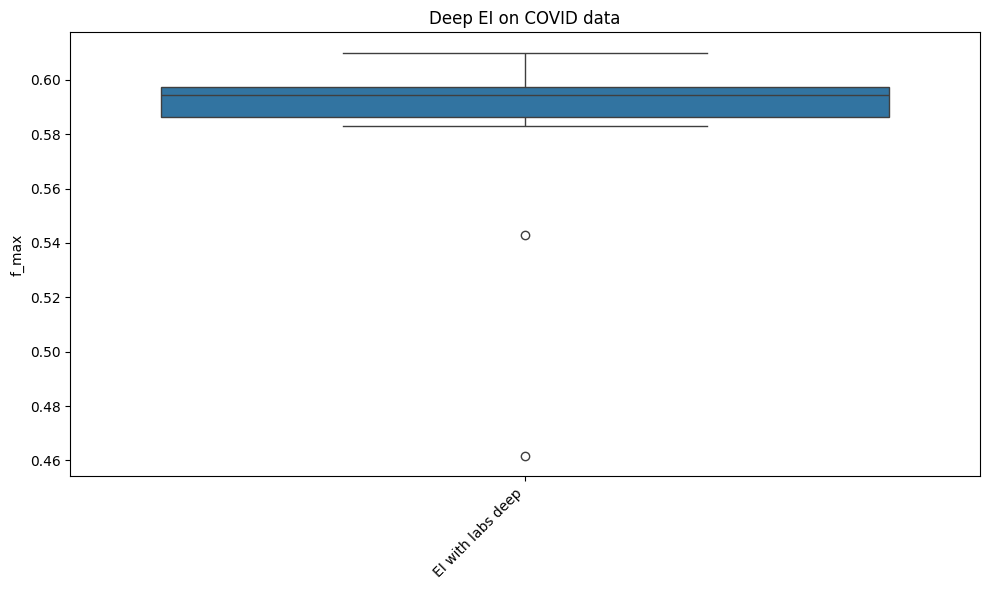

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'f_max'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.title("Deep EI on COVID data")
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
EI with labs deep,0.587243,0.594508,0.593472,0.582978,0.461538,0.59733,0.610043,0.54303,0.600238,0.59456,0.597209,0.597865


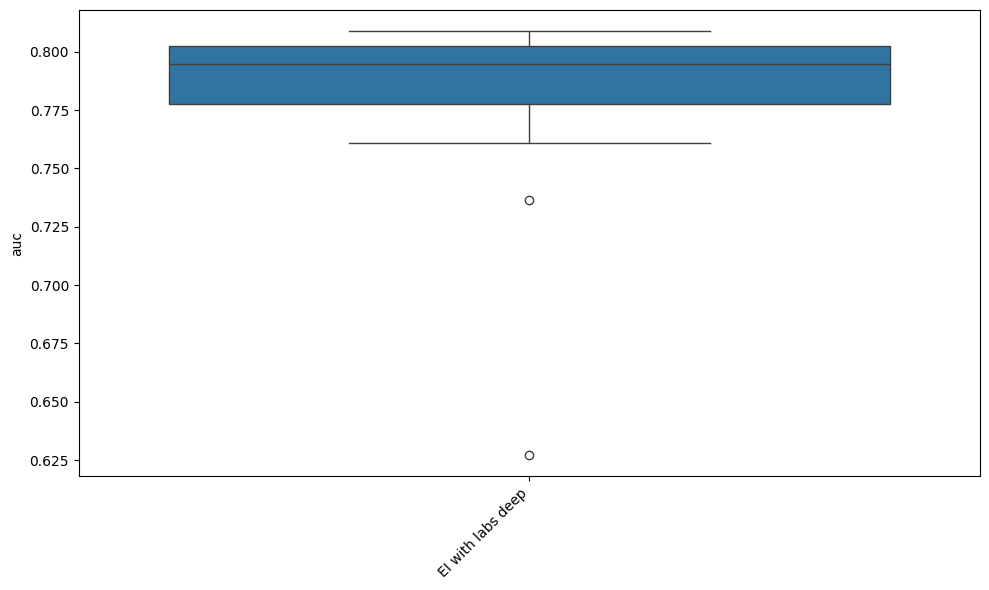

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'auc'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
admission,0.761031,0.756862,0.753303,0.720673,0.579215,0.742814,0.757926,0.694064,0.771042,0.767125,0.768544,0.691569
admission deep,0.758686,0.756817,0.757589,0.718621,0.600080,0.727212,0.753798,0.692039,0.765665,0.763349,0.765115,0.686143
EI with admission deep,0.820425,0.831318,0.820023,0.821231,0.628347,0.833407,0.836920,0.768504,0.842949,0.829779,0.831289,0.791135
comorbidities,0.574928,0.578629,0.560100,0.545048,0.520165,0.564757,0.566738,0.515650,0.586549,0.579131,0.580880,0.540861
comorbidities deep,0.586698,0.585158,0.559046,0.550285,0.543325,0.553722,0.567415,0.539949,0.582112,0.586073,0.582955,0.525751
EI with comorbidities deep,0.828858,0.833790,0.815168,0.809345,0.643609,0.830391,0.832511,0.772042,0.840393,0.832534,0.824633,0.786573
labs,0.800824,0.814680,0.800297,0.772254,0.634260,0.802590,0.813261,0.745175,0.818885,0.808592,0.815694,0.745408
labs deep,0.727711,0.738029,0.754873,0.731089,0.601849,0.743190,0.759917,0.699607,0.761392,0.746572,0.762766,0.696607
EI with labs deep,0.793817,0.792709,0.791026,0.798665,0.639818,0.809430,0.814431,0.749557,0.819380,0.803626,0.814590,0.774809
vitals,0.707028,0.701276,0.689987,0.658910,0.570378,0.678990,0.691548,0.640203,0.711458,0.710038,0.707073,0.635415


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data_fmax = {
    'admission': [0.5734265734265734, 0.5701078582434514, 0.5415617128463476, 0.5586776859504131, 0.580829756795422, 0.5531914893617021, 0.5505804311774462, 0.5929078014184397, 0.5783132530120483, 0.5763239875389408],
    'comorbidities': [0.4399293286219082, 0.44616709732988796, 0.45276292335115864, 0.4488330341113105, 0.448, 0.44665461121157324, 0.4446381865736704, 0.43453237410071943, 0.43996494303242767, 0.44786324786324794],
    'labs': [0.5371577574967406, 0.5903083700440529, 0.549237170596394, 0.4994663820704375, 0.5819209039548023, 0.5451851851851852, 0.5533834586466165, 0.5690140845070423, 0.56071964017991, 0.5757575757575758],
    'vitals': [0.5413333333333333, 0.5199306759098786, 0.5006016847172082, 0.5241157556270095, 0.5346534653465347, 0.5163120567375886, 0.5050215208034433, 0.5008130081300812, 0.5333333333333333, 0.5103857566765578],
    'EI': [0.623946037099494, 0.6388384754990926, 0.5924812030075187, 0.5745454545454546, 0.6459802538787024, 0.6376811594202898, 0.5988857938718662, 0.6324503311258278, 0.6088235294117648, 0.6319218241042345]
}

# Create a DataFrame from the data
df_fmax = pd.DataFrame(data_fmax)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_fmax = pd.melt(df_fmax, var_name='Box', value_name='fmax')

# Order boxes by median value in descending order
box_order_fmax = melted_df_fmax.groupby('Box')['fmax'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='fmax', data=melted_df_fmax, order=box_order_fmax)
plt.title('fmax')
plt.ylabel('fmax values')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# New Data
data_auc = {
    'admission': [0.7693368960628204, 0.7763605627658414, 0.7450430799432872, 0.7462754935107427, 0.770792889082779, 0.7577980150507143, 0.7505071436361654, 0.7867052023121386, 0.7761533427854729, 0.7670302104918748],
    'comorbidities': [0.5858681426545971, 0.6006898244083324, 0.5892790925946121, 0.6054913294797688, 0.6006434725706183, 0.6028792670956483, 0.5933962264150944, 0.5791389464499945, 0.5988330243210818, 0.5883438761042643],
    'labs': [0.745435707274512, 0.7772576071545426, 0.7408386956047552, 0.6439551750463519, 0.7786563420220307, 0.7274511942414658, 0.729921474533755, 0.7614570836514343, 0.7573890282473552, 0.790827789289999],
    'vitals': [0.723301341476715, 0.7141073181372014, 0.6892736394372342, 0.7114570836514342, 0.7110917221071, 0.7164358163376594, 0.6920111244410514, 0.6925019086050823, 0.7171011015377903, 0.7009870214854401],
    'EI': [0.8165612389573564, 0.8320809248554913, 0.7991220416621223, 0.7975079070781983, 0.8307449012978515, 0.8131911876976771, 0.8019413240266113, 0.8284109499400153, 0.8158905005998474, 0.8327952884720253]
}

# Create a DataFrame from the new data
df_auc = pd.DataFrame(data_auc)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_auc = pd.melt(df_auc, var_name='Box', value_name='auc')

# Order boxes by median value in descending order
box_order = melted_df_auc.groupby('Box')['auc'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='auc', data=melted_df_auc, order=box_order)
plt.title('EI vs modalities')
plt.ylabel('AUC')
plt.show()

In [ ]:
EI = e.EnsembleIntegration(
                        k_outer=5,
                        k_inner=5,
                        n_samples=1,
                        sampling_strategy="undersampling",
                        sampling_aggregation=None,
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name="diabetes",
                        model_building=True,
                        )

In [ ]:
for k,v in X_train.items():
    if k == "xgboost":
        EI.fit_base(v, y_train, modality_name=k, base_predictors=d_base_predictors)
    else:
        EI.fit_base(v, y_train, modality_name=k, base_predictors=base_predictors)

In [ ]:
EI.base_summary["metrics"]

In [ ]:
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

In [ ]:
EI.ensemble_summary["metrics"]

In [ ]:
preferred_ensemble_key = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
print(preferred_ensemble_key)
y_pred = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_key)
roc_auc_score(y_test, y_pred)

interpreter

In [ ]:
from eipy.interpretation import PermutationInterpreter

interpreter = PermutationInterpreter(EI=EI,
                                     metric=lambda y_test, y_pred: roc_auc_score(y_test, y_pred),
                                     ensemble_predictor_keys=preferred_ensemble_key,
                                     n_jobs=-1)

In [ ]:
EI.ensemble_predictors.keys()

In [ ]:
interpreter.rank_product_score(X_dict=X_test, y=y_test)